In [1]:
import numpy as np
import struct

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifierCV
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Homework 3

#### Load dataset

In [2]:
def load_digits_dataset() -> tuple[np.array, np.array, np.array, np.array]:
    """load the MNIST dataset from the files in the data directory"""
    with open('data/train-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        # print("This is the data after initial read in:", data.shape, sep=" ")
        Xtraindata = np.transpose(data.reshape((size, nrows*ncols)))

    with open('data/train-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytrainlabels = data.reshape((size,)) # (Optional)

    with open('data/t10k-images.idx3-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        nrows, ncols = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        Xtestdata = np.transpose(data.reshape((size, nrows*ncols)))

    with open('data/t10k-labels.idx1-ubyte','rb') as f:
        magic, size = struct.unpack(">II", f.read(8))
        data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
        ytestlabels = data.reshape((size,)) # (Optional)

    # I am transposing things for my convenience        
    return Xtraindata.T, ytrainlabels, Xtestdata.T, ytestlabels


# traindata_imgs =  np.transpose(Xtraindata).reshape((60000,28,28))    
# print(Xtraindata.shape)
# print(ytrainlabels.shape)
# print(Xtestdata.shape)
# print(ytestlabels.shape)

In [3]:
def plot_digits(XX: np.array, N: int, title: str, cmap: str = "Greys") -> None:
    """
    Plot the first N*N digits in the array XX
    
    :param XX: (d, N*N) array of digits
    :param N: number of digits to plot in each dimension
    :param title: title of the plot
    :param cmap: colormap

    :return: None
    """
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j].reshape((28, 28)), cmap=cmap)
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)
    filename = title.replace(" ", "_").lower()
    plt.savefig(f"visualizations/{filename}.png")

## Task 1

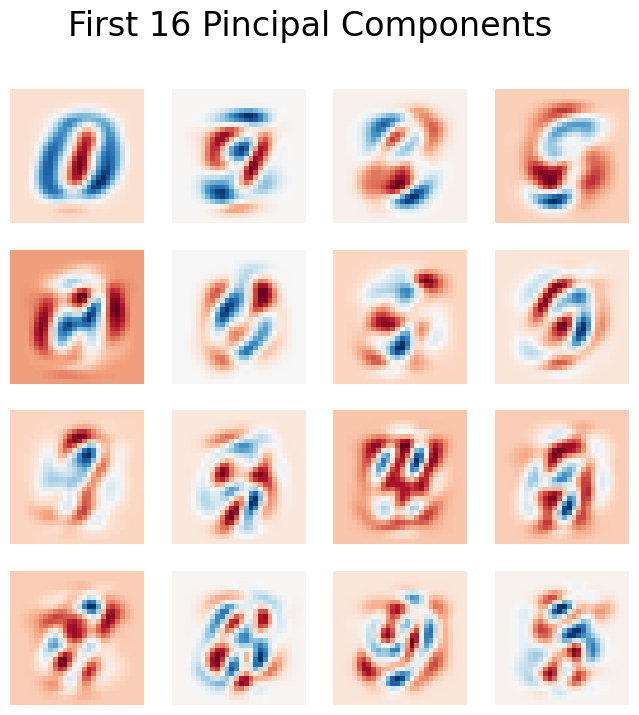

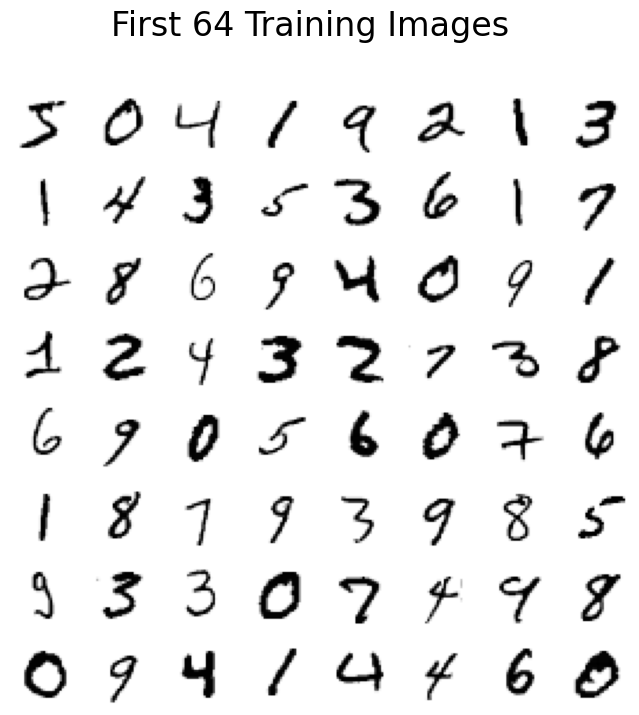

In [4]:
def do_task_one() -> None:
    """
    Task 1: Plot the first 16 digits in the dataset
    """
    X_train, y_train, X_test, y_test = load_digits_dataset()

    pca_16 = PCA(n_components=16)
    X_train_pca_16 = pca_16.fit_transform(X_train)

    plot_digits(pca_16.components_, 4, "First 16 Pincipal Components", cmap="RdBu")
    plot_digits(X_train, 8, "First 64 Training Images")

do_task_one()

## Task 2

In [5]:
def plot_energy_by_components(X_train: np.array, tolerance: float = 0.85) -> None:
    """plot the cumilative energy captured by the PCA components"""
    pca_model_for_task_2 = PCA()
    pca_model_for_task_2.fit(X_train)

    energy_by_components = np.cumsum(pca_model_for_task_2.singular_values_**2)/np.sum(pca_model_for_task_2.singular_values_**2)

    min_components = np.argmin(np.array([energy if energy >= tolerance else 100 for energy in energy_by_components])) + 1 # since the first one is 1 components not 0

    num_to_plot = 75

    fig = plt.figure(dpi=160)
    ax = fig.add_subplot(111)

    ax.axhline(y=tolerance, xmin=0, xmax=num_to_plot, color='r', linestyle='--', label=f'{tolerance*100}%', zorder=0)
    ax.plot(np.arange(1,115)[:num_to_plot], energy_by_components[:num_to_plot], 'o-', markersize=4, label="Energy Captured", zorder=1)
    ax.grid()
    ax.set_title("Energy Captured by PCA Components")
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Percent (%) Energy Captured")
    ax.scatter(min_components, energy_by_components[min_components-1], marker='*', color='orange', s=7, label=f"Min Components: {min_components}", zorder=2)
    

    ax.set_xticks(np.arange(0, num_to_plot, 5))
    ax.set_xlim(0, num_to_plot)
    plt.legend()
    plt.savefig("visualizations/energy_by_components.png") # TODO Update path
    plt.show()

    return min_components


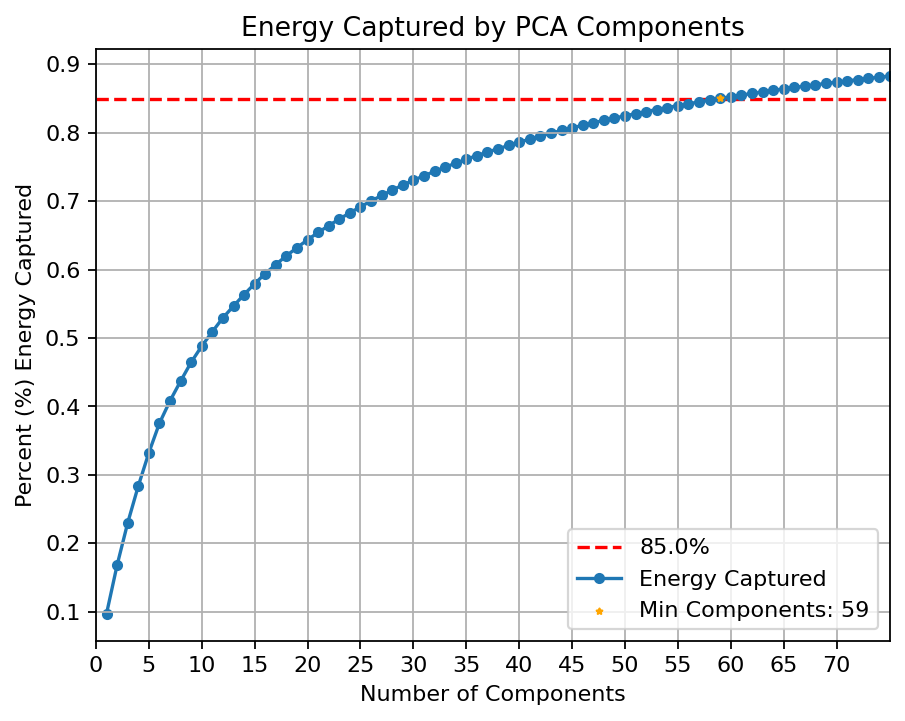

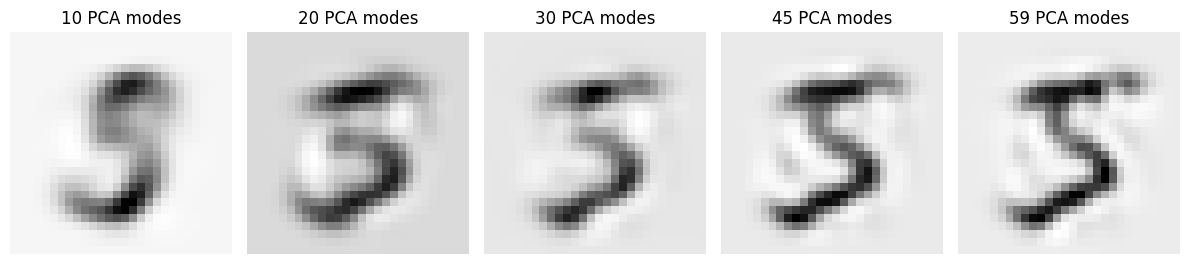

In [6]:
def plot_reconstruction(X: np.array, num_components: int, ax: Axes, digit_to_plot: int) -> None:
    pca = PCA(n_components=num_components)
    approx = pca.inverse_transform(pca.fit_transform(X))

    ax.imshow(approx[digit_to_plot].reshape((28,28)), cmap="Greys")
    ax.axis('off')
    ax.set_title(f"{num_components} PCA modes")

def plot_reconstruction_grid(X: np.array, num_components_list: list[int], digit_to_plot: int = 0) -> None:
    fig, axs = plt.subplots(1, 5, figsize=(12, 4))

    for ax, num_components in zip(axs.flat, num_components_list):
        plot_reconstruction(X=X, num_components=num_components, ax=ax, digit_to_plot=digit_to_plot)

    plt.tight_layout()
    plt.savefig("visualizations/digit_reconstruction.png")
    plt.show()

def do_task_two() -> None:
    """
    Task 2: Plot the energy captured by the PCA components
    """
    X_train, y_train, X_test, y_test = load_digits_dataset()
    num_components_85_percent_energy = plot_energy_by_components(X_train)
    plot_reconstruction_grid(X_train, [10, 20, 30, 45, num_components_85_percent_energy])

do_task_two()

In [7]:
# plot_this_digit = 0

# pca_10 = PCA(n_components=10)
# pca_20 = PCA(n_components=20)
# pca_30 = PCA(n_components=30)
# pca_45 = PCA(n_components=45)
# pca_85_perc_energy = PCA(n_components=num_components_85_percent_energy)

# approx_10 = pca_10.inverse_transform(pca_10.fit_transform(X_train))
# approx_20 = pca_20.inverse_transform(pca_20.fit_transform(X_train))
# approx_30 = pca_30.inverse_transform(pca_30.fit_transform(X_train))
# approx_45 = pca_45.inverse_transform(pca_45.fit_transform(X_train))
# approx_85_perc_energy = pca_85_perc_energy.inverse_transform(pca_85_perc_energy.fit_transform(X_train))

# fig = plt.figure(figsize=(12, 4))
# ax1 = fig.add_subplot(151)
# ax2 = fig.add_subplot(152)
# ax3 = fig.add_subplot(153)
# ax4 = fig.add_subplot(154)
# ax5 = fig.add_subplot(155)


# ax1.imshow(approx_10[plot_this_digit].reshape((28,28)), cmap="Greys")
# ax2.imshow(approx_20[plot_this_digit].reshape((28,28)), cmap="Greys")
# ax3.imshow(approx_30[plot_this_digit].reshape((28,28)), cmap="Greys")
# ax4.imshow(approx_45[plot_this_digit].reshape((28,28)), cmap="Greys")
# ax5.imshow(approx_85_perc_energy[plot_this_digit].reshape((28,28)), cmap="Greys")

# ax1.axis('off')
# ax2.axis('off')
# ax3.axis('off')
# ax4.axis('off')
# ax5.axis('off')

# ax1.set_title("10 PCA modes")
# ax2.set_title("20 PCA modes")
# ax3.set_title("30 PCA modes")
# ax4.set_title("45 PCA modes")
# ax5.set_title(f"{num_components_85_percent_energy} PCA modes")

## Task 3

In [8]:
def select_subset_of_digits_dataset(
    X_train: np.array,
    y_train: np.array,
    X_test: np.array,
    y_test: np.array,
    first_dig: int,
    second_dig: int,
) -> tuple[np.array, np.array, np.array, np.array]:
    """
    Select a subset of the digits dataset
    
    :param X: (N, d) N samples of d-dimensional data
    :param y: (N,) array of labels
    """
    train_mask = (y_train == first_dig) | (y_train == second_dig)
    test_mask = (y_test == first_dig) | (y_test == second_dig)

    return X_train[train_mask], y_train[train_mask], X_test[test_mask], y_test[test_mask]

## Task 4

Select the digits 1,8 using step 3, project the data onto 𝑘-PC modes computed in steps 1-2, and apply the Ridge classifier (linear) to distinguish between these two digits.
Perform cross-validation and testing and discuss your results.

In [9]:
def train_ridge_classifier(digits: tuple[int, int]) -> None:
    X_train, y_train, X_test, y_test = load_digits_dataset()
    
    X_train_1_8_sub, y_train_1_8_sub, X_test_1_8_sub, y_test_1_8_sub = select_subset_of_digits_dataset(
        X_train, y_train, X_test, y_test, first_dig=digits[0], second_dig=digits[1],
    )

    ridge = RidgeClassifierCV(alphas=1)
    # before training you should add the PCA step
    pca = PCA(n_components=29)

    pipeline = Pipeline(steps=[('pca', pca), ('ridge', ridge)])

    pipeline.fit(X_train_1_8_sub, y_train_1_8_sub)

    print("Accuracy on train set:", pipeline.score(X_train_1_8_sub, y_train_1_8_sub))
    print("Accuracy on test set:", pipeline.score(X_test_1_8_sub, y_test_1_8_sub))

train_ridge_classifier((1, 8))

Accuracy on train set: 0.9631541332486302
Accuracy on test set: 0.9791370317686107


## Task 5

Repeat the same classification procedure for pairs of digits 3,8 and 2,7.
Report your results and compare them with the results in step 4.
If there is any difference can you explain it?

## Task 6
Use all the digits and perform multi-class classification with Ridge, KNN and LDA classifiers.
Report your results and discuss how they compare between the methods.
Which method performs the best?

In [ ]:
# Now do ALl digits for Ridge, KNN, and LDA

## Task 7
Bonus (+2 points): Implement an alternative classifier, that we did not cover in class, (e.g. SVM), and compare its results with the classifiers in the previous step.

## OH Notes:
* Make it clear that you know what you are doing and why you are doing it.
* For that stage of the problem how does this relate to it
* She prefers pseudo code but its not required
* Don't be complicated...
* Describe classifiers in section two or three
* 